**The idea is build a CNN for clasificate images of the dataset "cifar10", the which content cars, boats, airplanes, etc.**

In [18]:
#Packages:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.datasets import cifar10

#Packages from optimizing the model:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt


In [2]:
#Load the data:
(x_train, y_train), (x_test, y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 17s 0us/step


In [3]:
x_train.shape #I have 50000 images of train where every one have resolution of 32x32 and is in RGB space color

(50000, 32, 32, 3)

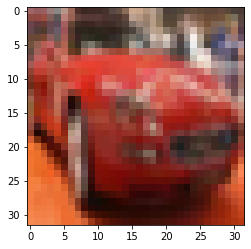

In [4]:
#Painting a image:
plt.imshow(x_train[5])

#Preprocessing:

In [5]:
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")/255

In [6]:
len(np.unique(y_train)) #I have only 10 classes

10

In [7]:
#Binarizing the labels:
y_train=to_categorical(y_train,10)
y_test=to_categorical(y_test,10)

In [8]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [9]:
#Normalizing the data lessing the mean and the standard desviation to every data (This stayes the data between 0 and 1):
mean=np.mean(x_train)
sd=np.std(x_train)
#I add a very samll number in the denominator for if the sd=0
x_train=(x_train-mean)/(sd+1e-7)
x_test=(x_test-mean)/(sd+1e-7) #IU normalize with the mean and the sd of the train set because the idea is that the network doesn´t know these parameters of the test set 

In [10]:
#Train_test_val_split:
(x_train,x_valid)=x_train[5000:],x_train[:5000]
(y_train,y_valid)=y_train[5000:],y_train[:5000]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((45000, 32, 32, 3), (45000, 10), (5000, 32, 32, 3), (5000, 10))

#Data Augmentation:

In [15]:
datagen=ImageDataGenerator(rotation_range=15,
                   width_shift_range=0.1,
                   height_shift_range=0.1,
                   horizontal_flip=True,
                   vertical_flip=True
                   )

#Building the model

In [11]:
base_filtros=32 #Number of Kernels in the convolutional layers
w_regularizer=1e-4 #weight of the relularizer

In [12]:
from keras.api._v2.keras import regularizers
model=Sequential()

#First convolution layer:
model.add(Conv2D(base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer), input_shape=(32,32,3))) #put a regularizer with l2
model.add(Activation("relu")) #Put a Activation layer of type relu
model.add(BatchNormalization()) #BatchNormalization Layer

#Second convolution layer:
model.add(Conv2D(base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer))) #put a regularizer with l2
model.add(Activation("relu")) #Put a Activation layer of type relu OR SIMPLY I COULD PUT A ACTIVATION FUNCTION IN THE CONVOLUTIONAL LAYER
model.add(BatchNormalization()) #BatchNormalization Layer
model.add(MaxPooling2D(pool_size=(2,2))) #First MaxPooling Layer
model.add(Dropout(0.2))


#Convolution layer number 3 (Iqual but increase the number of kernels):
model.add(Conv2D(2*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer))) #put a regularizer with l2
model.add(Activation("relu")) #Put a Activation layer of type relu
model.add(BatchNormalization()) #BatchNormalization Layer
model.add(Dropout(0.2))


#Convolution layer number 4:
model.add(Conv2D(2*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer))) #put a regularizer with l2
model.add(Activation("relu")) #Put a Activation layer of type relu
model.add(BatchNormalization()) #BatchNormalization Layer
model.add(MaxPooling2D(pool_size=(2,2))) #Second MaxPooling Layer
model.add(Dropout(0.3))



#Convolution layer number 5 (increase the number of kernels):
model.add(Conv2D(4*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer))) #put a regularizer with l2
model.add(Activation("relu")) #Put a Activation layer of type relu
model.add(BatchNormalization()) #BatchNormalization Layer

#Convolution layer number 6:
model.add(Conv2D(4*base_filtros,(3,3),padding="same",kernel_regularizer=regularizers.l2(w_regularizer))) #put a regularizer with l2
model.add(Activation("relu")) #Put a Activation layer of type relu
model.add(BatchNormalization()) #BatchNormalization Layer
model.add(MaxPooling2D(pool_size=(2,2))) #MaxPooling Layer Number three
model.add(Dropout(0.4))

#Classifiation (with dense layer) and Flatten:
model.add(Flatten())
model.add(Dense(10,activation="softmax"))


**How we can see, generally after of a convolution layer, there is a activation layer and generally after of a activation layer there is a Batch Normalization layer **

In [13]:
#architecture of the model:
model.summary() #Efectly the convolution layers increase the depth of my tensor and the pooling layer decrease the resolution of my tensor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

In [21]:
#Compile the model:
model.compile(metrics=["accuracy"],loss="categorical_crossentropy",optimizer=optimizers.Adam())

In [24]:
#Define the checkpoint:
checkpoint=ModelCheckpoint("best_model.hdf5",verbose=1,save_best_only=True,monitor="val_accuracy")

In [26]:
#Training the model including the data augmentation and a checkpoint:
history=model.fit(datagen.flow(x_train,y_train,batch_size=128),callbacks=[checkpoint],steps_per_epoch=x_train.shape[0]//128,epochs=120,validation_data=(x_valid,y_valid),verbose=2)

Epoch 1/5

Epoch 1: val_accuracy improved from 0.50260 to 0.57060, saving model to best_model.hdf5
351/351 - 23s - loss: 1.3786 - accuracy: 0.5531 - val_loss: 1.3794 - val_accuracy: 0.5706 - 23s/epoch - 66ms/step
Epoch 2/5

Epoch 2: val_accuracy improved from 0.57060 to 0.62840, saving model to best_model.hdf5
351/351 - 23s - loss: 1.2808 - accuracy: 0.5840 - val_loss: 1.1865 - val_accuracy: 0.6284 - 23s/epoch - 65ms/step
Epoch 3/5

Epoch 3: val_accuracy did not improve from 0.62840
351/351 - 23s - loss: 1.2011 - accuracy: 0.6064 - val_loss: 1.2871 - val_accuracy: 0.5978 - 23s/epoch - 66ms/step
Epoch 4/5

Epoch 4: val_accuracy improved from 0.62840 to 0.65180, saving model to best_model.hdf5
351/351 - 23s - loss: 1.1324 - accuracy: 0.6254 - val_loss: 1.1066 - val_accuracy: 0.6518 - 23s/epoch - 65ms/step
Epoch 5/5

Epoch 5: val_accuracy did not improve from 0.65180
351/351 - 23s - loss: 1.0787 - accuracy: 0.6444 - val_loss: 1.1410 - val_accuracy: 0.6412 - 23s/epoch - 65ms/step


In [27]:
#loading_the_best_model:
model.load_weights("/content/best_model.hdf5")

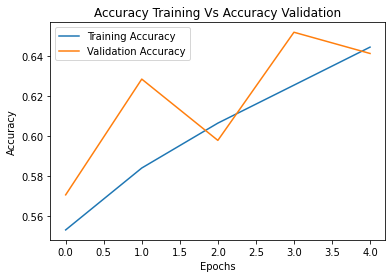

In [28]:
#Plotting the accuracy:
plt.plot(history.history["accuracy"],label="Training Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Training Vs Accuracy Validation")
plt.legend(loc="best")

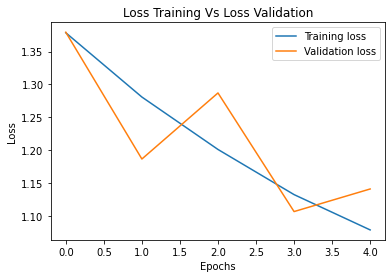

In [29]:
#Plotting the loss:
plt.plot(history.history["loss"],label="Training loss")
plt.plot(history.history["val_loss"],label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Training Vs Loss Validation")
plt.legend(loc="best")

In [30]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 3.5159 - accuracy: 0.1000


[3.5158886909484863, 0.10000000149011612]

**Obviously the model will be the more optimus if I put many many epochs**